# Import libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#np.random.seed(42)

# Define the function to learn

In [1]:
def Function(x,y):
    r2 = x**2 + y**2
    return (np.exp(-5*r2)*np.abs(x + y)).reshape([-1,1])
# we reshape the output so that it is an array of size Bx1 (the network has only 1 output)

In [2]:
def get_batch(batchsize):
    y_in = np.random.uniform(low=-0.5,high=0.5,size=[batchsize,2])
    f_out = Function(y_in[:,0],y_in[:,1])
    return (y_in, f_out)

# Define the neural network

### Definitions
We consider a neural network with $l = 0,\ldots, L-1$ layers (i.e. $L$ layers) with $n_l$ neurons each.

We consider a list of weights $w^{l}$. Each element of this list is a matrix $n_{l+1}\times n_l$. 
Likewise, we consider a list of biases $b^{l}$, whose elements are vectors of size $n_{l+1}$. We name the neurons of each layer as $k_l = 0, \ldots, n_l -1$.

Let the input of the neural network be $y_0$. Since we are using batches of samples, its size is $B\times n_0$, where $B$ is the batch size and $n_0$ the number of inputs of the network.

The linear output of the $l+1$ layer is (repeated indices are summed)
\begin{equation}
z^{(l+1)}_{k_{l+1}} = w^{(l)}_{k_{l+1},k_l} y^{(l)}_{k_l} + b^{(l)}_{k_{l+1}}
\end{equation}

Thus, by element-wise applying the activation function $f^{(l)}$, we have
\begin{equation}
y^{(l)}_{k_l} = f(z^{(l)}_{k_l}).
\end{equation}

In particular, we will apply the `ReLU` activation function on all the layers but the last one, on which we just sum the outputs.

In [4]:
nL = [2,30,30,30,30,1]
L = len(nL) - 1 # we do not consider the input as a layer

In [5]:
w = [np.random.uniform(low=-0.5,high=0.5,size=[nL[l+1],nL[l]]) for l in range(0,L)]
b = [np.zeros(nL[l+1]) for l in range(0,L)]

### Feed-forward propagation
The output of layer $l+1$ must have shape $B\times n_{l+1}$. As a consequence, using our notation, we will apply one layer with

``` y_new = np.dot(y_old, w.transpose()) + b ```

$[B\times n_{l+1}] = [B\times n_{l}]\text{   } [n_{l}\times n_{l+1}] + [n_{l+1}]$

In [6]:
# ReLU activation function
def sigmoid_ddz(z):
    val=z*(z>0)
    return val,z>0 

def sigmoid_ddz_last(z):
    val=z
    return val,1 

def apply_layer(y_in, w, b, f):
    z = np.dot(y_in, w.transpose()) + b
    return f(z)

def forward(y_in):
    y[0] = y_in

    for l in range(0,L-1):
        (y_in, df_dz[l]) = apply_layer(y_in, w[l], b[l], sigmoid_ddz)
        y[l+1] = y_in
    
    (y_in, df_dz[L-1]) = apply_layer(y_in, w[L-1], b[L-1], sigmoid_ddz_last)
    y[L] = y_in
        
    return y_in

### Backward propagation

We choose the best weights and biases for the network by minimizing the cost function. In this way we do not need to manually adjust the parameters of the network as we did in the function approximation example, but they will be found automatically.

We minimize the cost function through the Stochastic Gradient Descent algorithm. In other words, we update each weight and bias of the network according to
\begin{equation}
\begin{cases}
w^{(l),\text{ new}}_{k_{l+1}, k_l} = w^{(l)}_{k_{l+1}, k_l} - \eta \frac{\partial C}{\partial w^{(l)}_{k_{l+1}, k_l}} \\
b^{(l),\text{ new}}_{k_l} = b^{(l)}_{k_l} - \eta \frac{\partial C}{\partial b^{(l)}_{k_l}}
\end{cases}
\end{equation}
where $\eta$ is a free parameter of the algorithm called learning rate.

The cost function we use is the mean squared error between the output of the network and the true value of the function
\begin{equation}
 C =  \frac{1}{2} \langle \left\lVert y^{(L)}\left(y^{(0)}\right) - F\left(y^{(0)}\right) \right\rVert^2_2\rangle_{y^{(0)}} = 
 \\ = \frac{1}{2B} \sum_b^B \left\lVert y^{(L)}\left(y^{(0)}_b\right) - F\left(y^{(0)}_b\right) \right\rVert^2_2
\end{equation}
where the average over all possible inputs $y_0$ is approximated over a batch of $B$ samples. In our case, since the network has a single output, the 2-norm in the cost function is just the square.



In [7]:
def C(y_out,f_out):
    return 0.5*np.mean(np.sum((f_out-y_out)**2,axis=-1))

The backpropagation is the algorithm we use to calculate the partial derivatives of the cost function with respect to the weights and the biases. This algorithm allows a huge speed-up when compared to the numerical calculation of all derivatives (i.e. the change of the cost function when making a small change on the parameter), in particular in the case of very big networks with lots of parameters.

Let's calculate the partial derivative of the cost function with respect to a weight in the last layer
\begin{equation}
\frac{\partial C}{\partial w^{(L-1)}_{k_{L},k_{L-1}}} =
\frac{1}{B} \sum_b^B \left( y^{(L)}_{j_L} - F_{j_L} \right) \frac{\partial y^{(L)}_{j_L}}{\partial w^{(L-1)}_{k_{L},k_{L-1}}} =
\\ = \frac{1}{B} \sum_b^B \left( y^{(L)}_{j_L} - F_{j_L} \right) \frac{df\left(z^{(L)}_{j_L}\right)}{dw^{(L-1)}_{k_{L},k_{L-1}}} =
\\ =  \frac{1}{B} \sum_b^B \left( y^{(L)}_{j_L} - F_{j_L} \right) \frac{df(z)}{dz}\Big|_{z^{(L)}_{j_L}} 
\frac{\partial z^{(L)}_{j_L}}{\partial w^{(L-1)}_{k_{L},k_{L-1}}} =
\\ = \frac{1}{B} \sum_b^B \left( y^{(L)}_{k_L} - F_{k_L} \right) \frac{df(z)}{dz}\Big|_{z^{(L)}_{k_L}} 
y^{(L-1)}_{k_{L-1}} =
\\ = \frac{1}{B} \sum_b^B \Delta^{(L)}_{k_L} y^{(L-1)}_{k_{L-1}}
\end{equation} 

where $F_{n_L} = F\left(y^{(0)}\right)_{n_L}$ and we omitted the $b$ label in $y$, $z$ and $F$. We defined

\begin{equation}
\Delta^{(L)}_{k_L} = \left( y^{(L)}_{k_L} - F_{k_L} \right) \frac{df(z)}{dz}\Big|_{z^{(L)}_{k_L}}.
\end{equation}

We highlight that $ [\Delta^{(L)}] = [B \times n_L] $ and $ [y^{(L-1)}_{k_{L-1}}] = [B\times n_{L-1}] $. Thus, $\left[\frac{\partial C}{\partial w^{(L-1)}_{k_{L},k_L}} \right] = [n_L \times n_{L-1}] $ as we expected. We can implement it with

``` np.dot(Delta.transpose(), y)  ```


By the same token,
\begin{equation}
\frac{\partial C}{\partial b^{(L-1)}_{k_L}} = \frac{1}{B} \sum_b^B \Delta^{(L)}_{k_L}
\end{equation}

If the weight with respect to which we are differentiating is not in the last layer, we keep employing the chain rule. For example, if it belongs to the second-last layer, we have
\begin{equation}
\frac{\partial C}{\partial w^{(L-2)}_{k_{L-1},k_{L-2}}} =
\frac{1}{B} \sum_b^B \Delta^{(L)}_{j_L}\frac{dz^{(L)}_{j_L}}{dw^{(L-2)}_{k_{L-1},k_{L-2}}} =
\\ = \frac{1}{B} \sum_b^B \Delta^{(L)}_{j_L}  w^{(L-1)}_{j_{L},j_{L-1}} \frac{\partial  y^{(L-1)}_{j_{L-1}} }{\partial w^{(L-2)}_{k_{L-1},k_{L-2}}} = 
\\ = \frac{1}{B} \sum_b^B \Delta^{(L)}_{j_L}  w^{(L-1)}_{j_{L},j_{L-1}} \frac{df(z)}{dz}\Big|_{z^{(L-1)}_{j_{L-1}}} 
\frac{\partial z^{(L-1)}_{j_{L-1}}}{\partial w^{(L-2)}_{k_{L-1},k_{L-2}}} =
\\ =  \frac{1}{B} \sum_b^B \Delta^{(L)}_{j_L} M^{(L-1)}_{j_L,j_{L-1}} \frac{\partial z^{(L-1)}_{j_{L-1}}}{\partial w^{(L-2)}_{k_{L-1},k_{L-2}}} = 
\\ =  \frac{1}{B} \sum_b^B  \Delta^{(L)}_{j_L} M^{(L-1)}_{j_L,k_{L-1}} y^{(L-2)}_{k_{L-2}} =
\\ = \frac{1}{B} \sum_b^B  \Delta^{(L-1)}_{k_{L-1}} y^{(L-2)}_{k_{L-2}}
\end{equation}
where we defined 
\begin{equation}
M^{(L-1)}_{j_L,j_{L-1}} = w^{(L-1)}_{j_{L},j_{L-1}} \frac{df(z)}{dz}\Big|_{z^{(L-1)}_{j_{L-1}}} 
\end{equation}

We highlight that $[M^{(L-1)}] = [n_L \times n_{L-1}] $. We define
\begin{equation}
\Delta^{(L-1)}_{k_{L-1}} = \Delta^{(L)}_{j_L} M^{(L-1)}_{j_L,k_{L-1}}
\end{equation}
with shape $[\Delta^{(L-1)}] = [B \times n_{L-1}]$.
As before, we calculate it with
``` np.dot(Delta.transpose(), y)  ```.

Again, 
\begin{equation}
\frac{\partial C}{\partial b^{(L-2)}_{k_{L-1}}} =
\frac{1}{B} \sum_b^B  \Delta^{(L)}_{j_L} M^{(L-1)}_{j_L,k_{L-1}} =
\\ = \frac{1}{B} \sum_b^B  \Delta^{(L-1)}_{k_{L-1}}
\end{equation}

By iteration, by defining in general
\begin{equation}
M^{(l-1)}_{j_l,j_{l-1}} = w^{(l-1)}_{j_{l},j_{l-1}} \frac{df(z)}{dz}\Big|_{z^{(l-1)}_{j_{l-1}}}  \\
\Delta^{(l-1)}_{k_{l-1}} = \Delta^{(l)}_{j_l} M^{(l-1)}_{j_l,k_{l-1}}
\end{equation}
we get the equations of the derivatives of the cost function with respect to the weights and the biases:
\begin{equation}
\frac{\partial C}{\partial w^{(l-1)}_{k_{l},k_{l-1}}} = \frac{1}{B} \sum_b^B  \Delta^{(l)}_{k_{l}} y^{(l-1)}_{k_{l-1}} \\
\frac{\partial C}{\partial b^{(l-1)}_{k_{l}}} = \frac{1}{B} \sum_b^B  \Delta^{(l)}_{k_{l}}
\end{equation}

We see that we can calculate these derivatives by storing $\Delta^{(l)}$, the derivatives of the activation functions calculated at the correct value $\frac{df}{dz}$ and the output of each layer $y^{(l)}$.

In [8]:
Delta = [np.zeros(0) for l in range(0, L)]
df_dz = [np.zeros(0) for l in range(0, L)]
y = [np.zeros(nL[l]) for l in range(0, L + 1)]

dw = [np.zeros([nL[l+1], nL[l]]) for l in range(0, L)]
db = [np.zeros(nL[l+1]) for l in range(0, L)]

In [9]:
def backward(y_in, y_out, f_out):
    batchsize = len(y_in)
    Delta[-1]= (y_out - f_out)*df_dz[-1]
    
    dw[-1] = np.dot(Delta[-1].transpose(), y[-2])/batchsize
    db[-1] = np.sum(Delta[-1], axis=0)/batchsize
    
    for l in range(0,L-1):
        M = np.dot(Delta[-1-l], w[-1-l])
        Delta[-2-l] =M*df_dz[-2-l]
        
        dw[-2-l] = np.dot(Delta[-2-l].transpose(), y[-3-l])/batchsize
        db[-2-l] = np.sum(Delta[-2-l], axis=0)/batchsize

In [10]:
def train(batchsize, eta = 0.1):
    y_in, f_out = get_batch(batchsize)
    y_out = forward(y_in)
    
    backward(y_in,y_out,f_out)
    
    for l in range(0, L):
        w[l]-= eta*dw[l]
        b[l]-= eta*db[l]
        
    return C(y_out,f_out)

# Train the network

In [11]:
costs=[]
N_batch = 2000
batchsize = 1000
eta = 0.1

In [12]:
for k in range(N_batch):
    costs.append(train(batchsize, eta))
    
    if k%(int(N_batch/20)) == 0:
        print("Training: %d/%d, Cost = %2.7f" % (k,N_batch,costs[-1]))
print("Network has been trained: final cost %.10e" %costs[-1])
print("Did we overfit?")

Training: 0/2000, Cost = 0.0150332
Training: 100/2000, Cost = 0.0010467
Training: 200/2000, Cost = 0.0007438
Training: 300/2000, Cost = 0.0004806
Training: 400/2000, Cost = 0.0004316
Training: 500/2000, Cost = 0.0003266
Training: 600/2000, Cost = 0.0002394
Training: 700/2000, Cost = 0.0002556
Training: 800/2000, Cost = 0.0002052
Training: 900/2000, Cost = 0.0001845
Training: 1000/2000, Cost = 0.0001619
Training: 1100/2000, Cost = 0.0001434
Training: 1200/2000, Cost = 0.0001411
Training: 1300/2000, Cost = 0.0001482
Training: 1400/2000, Cost = 0.0001188
Training: 1500/2000, Cost = 0.0001133
Training: 1600/2000, Cost = 0.0000875
Training: 1700/2000, Cost = 0.0000963
Training: 1800/2000, Cost = 0.0000794
Training: 1900/2000, Cost = 0.0000964
Network has been trained: final cost 7.3591652536e-05
Did we overfit?


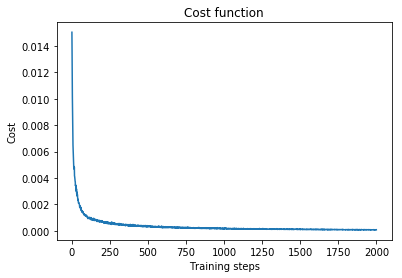

In [13]:
plt.figure()
plt.title("Cost function")
plt.plot(costs)
plt.xlabel("Training steps")
plt.ylabel("Cost")
plt.show()


# Evaluate the model and plot the results

In [14]:
x_start = -0.5
x_end = 0.5

y_start = -0.5
y_end = 0.5

Mx = 100
x_in = np.linspace(x_start,x_end,Mx)

My = 100
y_in = np.linspace(y_start,y_end,My)

x_test, y_test = np.meshgrid(x_in, y_in)

net_in = np.array([x_test.flatten(),y_test.flatten()]).transpose()
f_out = forward(net_in)
f_out = f_out.reshape([My,Mx])

f_true = Function(x_test,y_test)

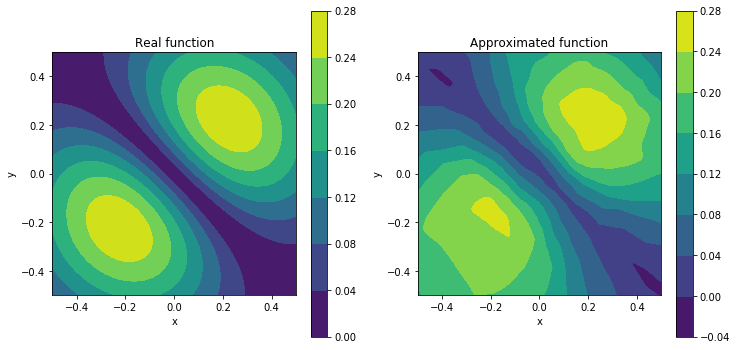

In [15]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.contourf(x_test,y_test,f_true.reshape([My,Mx]))
plt.title("Real function")
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()

plt.subplot(1,2,2)
plt.contourf(x_test,y_test,f_out)
plt.title("Approximated function")
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()


plt.show()

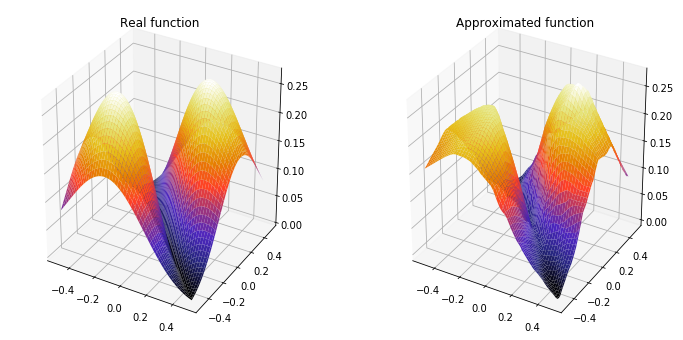

In [16]:
fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(1,2,1,projection="3d")
plt.title("Real function")
ax.plot_surface(x_test,y_test,f_true.reshape([My,Mx]), cmap=plt.cm.CMRmap)

ax = fig.add_subplot(1,2,2, projection="3d")
plt.title("Approximated function")
ax.plot_surface(x_test,y_test,f_out, cmap=plt.cm.CMRmap)
plt.show()